In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jvxqhx1r because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
dataset_dim = 64

In [3]:
def ground_truth_parameterization(z1,z2):
    noise_size = 0.00
    x = np.arange(dataset_dim/2)
    y1 = scipy.stats.logistic.cdf(z1*np.sin(x*np.pi/((dataset_dim/2)-1)))
    y2 = scipy.stats.logistic.cdf(z2*np.sin(x*np.pi/((dataset_dim/2)-1)))
    #y = scipy.stats.logistic.cdf(z*np.ones_like(x))
    #y = y + np.random.uniform(-noise_size,noise_size,size=(y.shape))
    return (np.arange(dataset_dim),np.concatenate((y1,y2)))

zmax = 8


    
dataset = []
for z in np.linspace(0,zmax,10):
    x,y = ground_truth_parameterization(z,np.random.uniform(-1,1)*0.5)
    dataset.append(y)
dataset = np.array(dataset)

# 1D PCA Fit to Trajectories

In [4]:
mean = np.mean(dataset,axis=0)
u,s,vt = np.linalg.svd(dataset-mean)

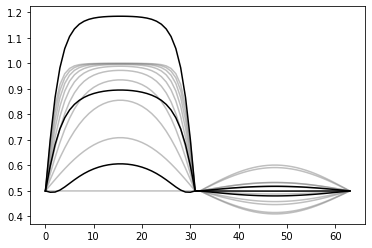

In [5]:
for data in dataset:
    plt.plot(np.arange(dataset_dim),data,c="gray",alpha=0.5)
plt.plot(np.arange(dataset_dim),mean              , c = "k")
plt.plot(np.arange(dataset_dim),mean + 1.5 * vt[0], c = "k")
plt.plot(np.arange(dataset_dim),mean - 1.5 * vt[0], c = "k")

# 1D VAE Fit to Dataset

In [6]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [7]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    

In [8]:
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [9]:
testname = "pedagogical/oned"

In [ ]:
all_models=[]
all_exceptions = []
for curvreg in [0,0.01,0.1,1]:
    for secreg in [0,0.01,0.1,1]:
        if curvreg != 0 and secreg != 0:
            continue
        for beta in [0.01]:
            for latentdim in [1]:
                for epsilon_scale_start in [2]:
                    try:
                        vae = make_vae(latent_dim=latentdim).to(device)
                        num_epochs = 300
                        savedir  = f'{testname}lat{latentdim}_secreg{secreg}_curvreg{curvreg}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                        print(savedir)
                        trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
                            log_dir=savedir, lr=0.0005, annealingBatches=0, record_loss_every=50, loss_func = "gaussian")
                        scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.1)
                        epoch = 0
                        epsilon_scale = epsilon_scale_start
                        for _ in range(num_epochs*3):
                            epoch+=1
                            # had an off-by-one error here before
                            # update values BEFORE training 501st element
                            if epoch % num_epochs == 1 and epoch > 1: 
                                scheduler.step()
                                trainer.beta = trainer.beta * 1.0 #0.1
                                epsilon_scale = epsilon_scale * 0.8 #0.1
                                curvreg = curvreg * np.sqrt(10)
                                secreg = secreg * np.sqrt(10)
                            embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=curvreg, epsilon_scale = epsilon_scale, num_new_samp_points=128)
                            is_error = embst[0]
                            if is_error:
                                raise Exception
                        sm.save_fcpassthrough_vae(vae, savedir)
                        print(savedir)
                        all_models.append(savedir)
                    except:
                        raise

pedagogical/onedlat1_secreg0_curvreg0_beta0.01_20220131-180641


In [24]:

colors=["red","yellow","green","orange","black","gray","blue"]

pedagogical/onedlat1_secreg0_curvreg0_beta0.01_20220131-180641
pedagogical/onedlat1_secreg0.01_curvreg0.0_beta0.01_20220131-180725
pedagogical/onedlat1_secreg0.1_curvreg0.0_beta0.01_20220131-180819
pedagogical/onedlat1_secreg1_curvreg0.0_beta0.01_20220131-180915
pedagogical/onedlat1_secreg0_curvreg0.01_beta0.01_20220131-181009
pedagogical/onedlat1_secreg0_curvreg0.1_beta0.01_20220131-181107
pedagogical/onedlat1_secreg0_curvreg1_beta0.01_20220131-181204


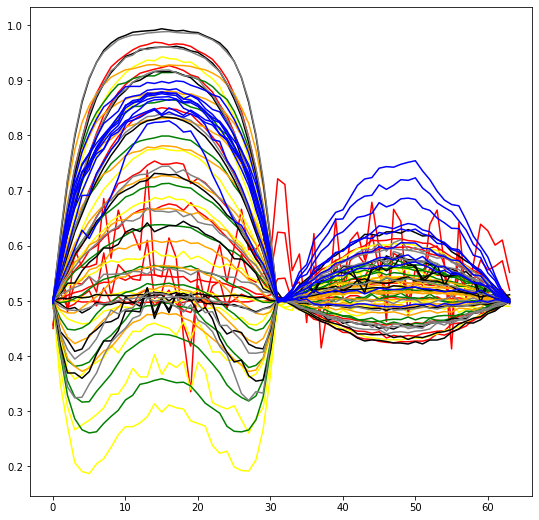

In [25]:
plt.figure(figsize=(9,9))
#for z in np.linspace(0,zmax,10):
#    x,y = ground_truth_parameterization(z)
#    plt.plot(x,y,c="k",alpha=0.9)
for i, modelpath in enumerate(all_models):
    print(modelpath)
    if i == 0:
        pass
    for z in np.linspace(-1,1,10):
        vae = lm.load_model(modelpath)
        yvals = vae.decode(torch.tensor(z*np.ones(shape=(1,1),dtype=np.float32)),
                    torch.tensor(np.zeros(shape=(1,0),dtype=np.float32)))[0].detach().cpu()
        plt.plot(yvals.flatten(),c=colors[i])
#for fact in np.linspace(-4,2,16):
#    plt.plot(np.arange(dataset_dim),mean + fact * vt[0], c = "red")

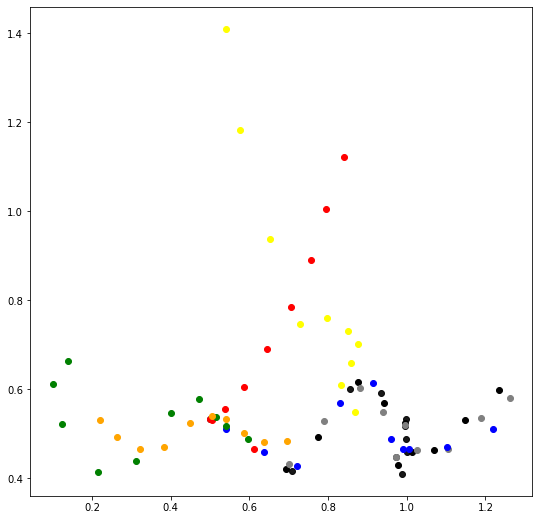

In [21]:
plt.figure(figsize=(9,9))
for y in dataset:
    plt.scatter(y[16],y[48],c="k",alpha=0.9)
for z in np.linspace(0,2,10):
    for i, modelpath in enumerate(all_models):
        vae = lm.load_model(modelpath)
        yvals = vae.decode(torch.tensor(z*np.ones(shape=(1,1),dtype=np.float32)),
                    torch.tensor(np.zeros(shape=(1,0),dtype=np.float32)))[0].detach().cpu().flatten()
        plt.scatter(yvals[16],yvals[48],c=colors[i])


pedagogical/onedlat1_secreg0_curvreg0_beta0.01_20220131-180641
pedagogical/onedlat1_secreg0.01_curvreg0.0_beta0.01_20220131-180725
pedagogical/onedlat1_secreg0.1_curvreg0.0_beta0.01_20220131-180819
pedagogical/onedlat1_secreg1_curvreg0.0_beta0.01_20220131-180915
pedagogical/onedlat1_secreg0_curvreg0.01_beta0.01_20220131-181009
pedagogical/onedlat1_secreg0_curvreg0.1_beta0.01_20220131-181107
pedagogical/onedlat1_secreg0_curvreg1_beta0.01_20220131-181204


(0.3, 1.1)

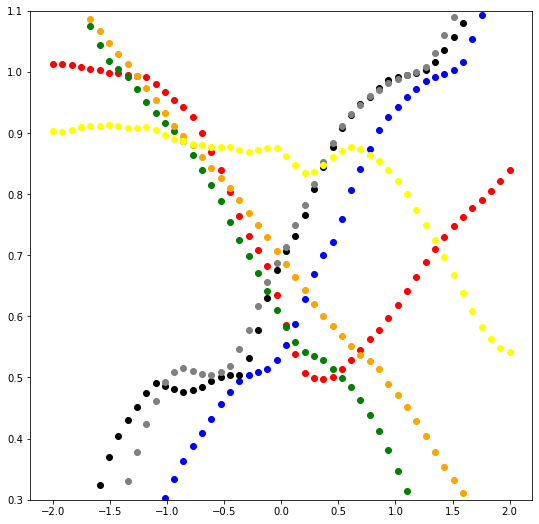

In [22]:
plt.figure(figsize=(9,9))
for i, modelpath in enumerate(all_models):
    print(modelpath)
    vae = lm.load_model(modelpath)
    for z in np.linspace(-2,2,50):
        yvals = vae.decode(torch.tensor(z*np.ones(shape=(1,1),dtype=np.float32)),
                    torch.tensor(np.zeros(shape=(1,0),dtype=np.float32)))[0].detach().cpu().flatten()
        plt.scatter(z,yvals[16],c=colors[i])
        #plt.scatter(z,yvals[0],c=colors[i])
plt.ylim((0.3,1.1))